# Proxy

In [117]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
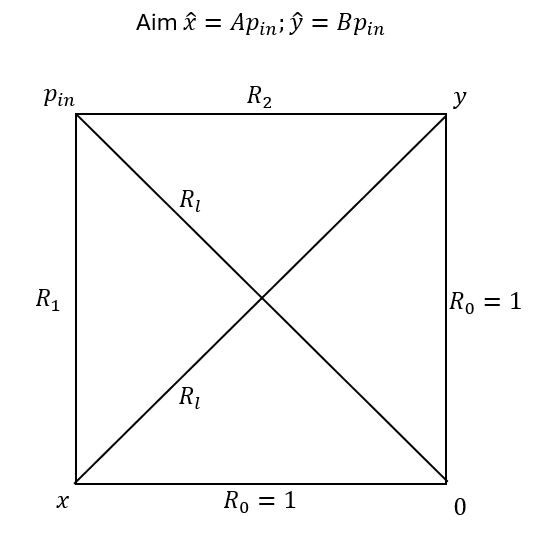
</div>


In [251]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.R_in_t = [np.array([1.,1.])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.out_clamped_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
        elif self.variabs.task_type == 'Regression':
            self.out_clamped_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[-1][0],
#                                  syms.p2:self.p_in_t[-1][1], syms.Rl:2**(1/2)})
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[0][0],
#                                  syms.p2:self.p_in_t[0][1], syms.Rl:2**(1/2)})
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.task_type=='Allostery':
            self.loss = loss_fn(self.output, desired)
        elif self.task_type=='Regression':
            self.loss = loss_fn(self.output, outputs_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.task_type == 'Allostery':
            # p_nxt = p - np.dot(state.variabs.alpha, loss) * self.t
            # p_nxt = p - np.dot(2*(1-np.e**-(state.variabs.alpha*self.t)), loss)
            # p_nxt = p - np.dot(self.variabs.alpha, loss*(1+self.bc_noise*pert))
            # p_nxt = p - np.dot(self.variabs.alpha, loss)       
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.task_type == 'Regression':
            p_prev = self.p_in_t[-2]
            p_nxt = p - np.dot(self.variabs.alpha, np.dot(p-p_prev, loss[0]-loss[1]))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_clamped = self.out_clamped_in_t[-1]
        if self.task_type=='Allostery':
            # self.output = self.out_in_t[-1] + 2*(1-np.e**-(state.variabs.alpha*self.t)) * self.loss_in_t[-1]
            # self.output = self.out_clamped_in_t[-1] + self.variabs.alpha * self.loss_in_t[-1] * (1+self.bc_noise*pert)
            # self.output = self.out_clamped_in_t[-1]
            # self.output = np.array([desired])
            self.output = out_clamped + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.task_type=='Regression':
            self.output = out_clamped + self.variabs.alpha * (loss[0]-loss[1])
        self.out_clamped_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('clamped output', self.output)
    
    def update_Rs(self):
        # R_nxt = R_in_t[-1] + self.variabs.gamma * (self.p_in_t[-1]-self.output) 
        # self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output[-1]))
        self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        # dummy function, fill later
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        print(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5

In [253]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.5
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.3
        B = 0.15
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
        
    training = 600
    
    for j, alpha in enumerate(alpha_vec):
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
#         print('p at t=0: ', state.p_in_t[0])
#         print('R at t=0: ', state.R_in_t[0])
        # if task_type=='Regression':
            # desired = np.dot(AB_vec, state.p_in_t[0])
        for i in range(training):
            if task_type=='Regression':
                # state.p_drawn = state.p_in_t[0]
                if not i % 0:
                    state.draw_p()
                    print('p_drawn', state.p_drawn)
                    # desired = np.dot(AB_vec, state.p_in_t[-1])
                    desired = np.dot(AB_vec, state.p_drawn)
                    print('desired', desired)
            state.calc_output(syms)
            state.calc_loss(desired)
            state.update_pressure()
            state.update_BCs(desired)
            state.update_Rs()
        
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
        return state, variabs, desired
            
def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x clamped', 'y clamped', 'p clamped']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x clamped', 'p1 clamped', 'p2 clamped']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(state.out_in_t)
    ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    ax1.set_title('x, y in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_clamped_in_t)
    ax2.plot(state.p_in_t)
    ax2.set_title('clamped and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t)
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, outputs2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

[1.30733977 0.63632385]
p_drawn [1.30733977 0.63632385]
desired 0.4876505082924164
output= 0.717985574477502
loss= -0.230335066185086
time= 1
p_nxt= [1.01181268280909 1.27719852452665]
clamped output [0.307144224200708]
R_nxt [0.704668458608386 0.970054300325941]
output= 0.795424632286413
loss= -0.307774123993997
time= 2
p_nxt= [1.50398779394519 1.60316357400113]
clamped output [0.324815740312610]
R_nxt [1.17917205363258 1.27834783368852]
output= 0.687280875184743
loss= -0.199630366892326
time= 3
p_nxt= [1.79488077723910 1.85935068475597]
clamped output [0.203928609964833]
R_nxt [1.59095216727426 1.65542207479114]
output= 0.621796674770298
loss= -0.134146166477882
time= 4
p_nxt= [2.03664084191798 1.97349816229326]
clamped output [0.282752760077887]
R_nxt [1.75388808184009 1.69074540221537]
output= 0.600277183041195
loss= -0.112626674748779
time= 5
p_nxt= [2.13077247596263 1.95921891991733]
clamped output [0.109630058742970]
R_nxt [2.02114241721966 1.84958886117436]
output= 0.5686348635

output= 0.479329730361620
loss= 0.00832077793079611
time= 52
p_nxt= [2.70209497390891 3.65342964212033]
clamped output [-0.0489275027862881]
R_nxt [2.75102247669520 3.70235714490661]
output= 0.482648263075505
loss= 0.00500224521691139
time= 53
p_nxt= [2.67778444037617 3.72252485804974]
clamped output [-0.185095983460657]
R_nxt [2.86288042383682 3.90762084151039]
output= 0.472061511693015
loss= 0.0155889965994017
time= 54
p_nxt= [2.70004405363081 3.60498267275396]
clamped output [-0.213235223325103]
R_nxt [2.91327927695592 3.81821789607906]
output= 0.468965253928476
loss= 0.0186852543639402
time= 55
p_nxt= [2.69666621360924 3.49108703752305]
clamped output [-0.124435089562740]
R_nxt [2.82110130317198 3.61552212708579]
output= 0.477828350407890
loss= 0.00982215788452612
time= 56
p_nxt= [2.58241772236053 3.40662636483085]
clamped output [-0.125539210477815]
R_nxt [2.70795693283835 3.53216557530866]
output= 0.487626128051152
loss= 2.43802412643879e-5
time= 57
p_nxt= [2.54257374722165 3.362

output= 0.475603487404102
loss= 0.0120470208883149
time= 105
p_nxt= [3.01872221518377 2.78344469338611]
clamped output [-0.0783897006717219]
R_nxt [3.09711191585550 2.86183439405783]
output= 0.467201138826999
loss= 0.0204493694654174
time= 106
p_nxt= [3.02540479552193 2.70768460598601]
clamped output [-0.0694253433919984]
R_nxt [3.09483013891393 2.77710994937801]
output= 0.468641754271231
loss= 0.0190087540211850
time= 107
p_nxt= [3.08368676091999 2.49913486693062]
clamped output [-0.135076132438746]
R_nxt [3.21876289335873 2.63421099936936]
output= 0.463518757284793
loss= 0.0241317510076238
time= 108
p_nxt= [2.96635927932162 2.56196952212516]
clamped output [-0.269965702684785]
R_nxt [3.23632498200640 2.83193522480994]
output= 0.459134646773097
loss= 0.0285158615193198
time= 109
p_nxt= [2.95789810867012 2.51968696619872]
clamped output [-0.237204596388580]
R_nxt [3.19510270505870 2.75689156258730]
output= 0.462811591144700
loss= 0.0248389171477167
time= 110
p_nxt= [2.92397818814670 2.

clamped output [-0.349829345158320]
R_nxt [2.52273124339031 2.55557671834438]
output= 0.513256827098559
loss= -0.0256063188061423
time= 156
p_nxt= [2.15749286655384 2.23691239782078]
clamped output [-0.298339639703799]
R_nxt [2.45583250625764 2.53525203752458]
output= 0.519196002488209
loss= -0.0315454941957929
time= 157
p_nxt= [2.20644300117400 2.32921674940673]
clamped output [-0.476426480651535]
R_nxt [2.68286948182553 2.80564323005826]
output= 0.497186979052580
loss= -0.00953647076016384
time= 158
p_nxt= [2.22472497233470 2.30992997459590]
clamped output [-0.614449866297503]
R_nxt [2.83917483863221 2.92437984089340]
output= 0.483886187616645
loss= 0.00376432067577093
time= 159
p_nxt= [2.27269304172579 2.36494857178717]
clamped output [-0.532209218335765]
R_nxt [2.80490226006155 2.89715779012294]
output= 0.486749381481726
loss= 0.000901126810690822
time= 160
p_nxt= [2.24920496289575 2.35342878362381]
clamped output [-0.536363472687991]
R_nxt [2.78556843558374 2.88979225631180]
outpu

output= 0.430796701547759
loss= -0.00568588657010421
time= 203
p_nxt= [1.38489008077771 2.27253999233916]
clamped output [-1.22446759576489]
R_nxt [2.60935767654259 3.49700758810405]
output= 0.443999456995595
loss= -0.0188886420179398
time= 204
p_nxt= [1.29358206057943 2.22333484382145]
clamped output [-1.09035090870029]
R_nxt [2.38393296927972 3.31368575252174]
output= 0.462608055084524
loss= -0.0374972401068689
time= 205
p_nxt= [1.20608139773468 2.16893434258646]
clamped output [-1.21974040892007]
R_nxt [2.42582180665475 3.38867475150653]
output= 0.458346571116113
loss= -0.0332357561384580
time= 206
p_nxt= [1.13026493978748 2.20449855233498]
clamped output [-1.26625892357167]
R_nxt [2.39652386335915 3.47075747590666]
output= 0.459183205752905
loss= -0.0340723907752501
time= 207
p_nxt= [1.18126687018561 2.28221797314683]
clamped output [-1.33067217106839]
R_nxt [2.51193904125400 3.61289014421522]
output= 0.448748860244889
loss= -0.0236380452672340
time= 208
p_nxt= [1.19630194795304 2.

output= 0.437271006868566
loss= -0.0121601918909107
time= 255
p_nxt= [1.56075572735939 2.45103768690279]
clamped output [-1.16089638086252]
R_nxt [2.72165210822191 3.61193406776531]
output= 0.434967360003805
loss= -0.00985654502614991
time= 256
p_nxt= [1.64458272093719 2.59075159801006]
clamped output [-1.11065673420667]
R_nxt [2.75523945514385 3.70140833221673]
output= 0.431461796275965
loss= -0.00635098129831008
time= 257
p_nxt= [1.68571827967183 2.47262021462440]
clamped output [-1.14543475772210]
R_nxt [2.83115303739393 3.61805497234650]
output= 0.428258987855506
loss= -0.00314817287785052
time= 258
p_nxt= [1.68841188175003 2.51195660988010]
clamped output [-1.14080968528065]
R_nxt [2.82922156703067 3.65276629516075]
output= 0.427796337460975
loss= -0.00268552248331982
time= 259
p_nxt= [1.68312015906762 2.54009291543475]
clamped output [-1.16243694019691]
R_nxt [2.84555709926453 3.70252985563166]
output= 0.426024149822036
loss= -0.000913334844380664
time= 260
p_nxt= [1.666305453480

output= 0.415535488001674
loss= 0.00957532697598101
time= 300
p_nxt= [2.08333908789089 2.31704275951242]
clamped output [-0.957537706682207]
R_nxt [3.04087679457309 3.27458046619463]
output= 0.423175234421488
loss= 0.00193558055616733
time= 301
p_nxt= [2.08932650210127 2.36178327471135]
clamped output [-0.929515712068962]
R_nxt [3.01884221417023 3.29129898678031]
output= 0.423963733316118
loss= 0.00114708166153693
time= 302
p_nxt= [2.15418748319975 2.42136534669087]
clamped output [-1.01161625361036]
R_nxt [3.16580373681011 3.43298160030122]
output= 0.413728574474563
loss= 0.0113822405030921
time= 303
p_nxt= [2.08781996472160 2.38620697600712]
clamped output [-1.00237548367332]
R_nxt [3.09019544839493 3.38858245968045]
output= 0.418360231883996
loss= 0.00675058309365889
time= 304
p_nxt= [2.04622944306131 2.39923942956608]
clamped output [-0.985115243485583]
R_nxt [3.03134468654690 3.38435467305166]
output= 0.421452943262691
loss= 0.00365787171496407
time= 305
p_nxt= [2.07477896403607 2

output= 0.426376300496785
loss= -0.00126548551913025
time= 355
p_nxt= [2.41678640114481 2.01483602587085]
clamped output [-0.698833942530130]
R_nxt [3.11562034367494 2.71366996840098]
output= 0.433057497307555
loss= -0.00794668232989998
time= 356
p_nxt= [2.49800620483561 1.93434040183305]
clamped output [-0.650344799212189]
R_nxt [3.14835100404780 2.58468520104524]
output= 0.435334562143166
loss= -0.0102237471655111
time= 357
p_nxt= [2.50371779547934 1.92789386917874]
clamped output [-0.710462677616301]
R_nxt [3.21418047309564 2.63835654679504]
output= 0.430833345390219
loss= -0.00572253041256432
time= 358
p_nxt= [2.44580432816374 1.85795211810933]
clamped output [-0.655891940005645]
R_nxt [3.10169626816939 2.51384405811497]
output= 0.439595923150142
loss= -0.0144851081724873
time= 359
p_nxt= [2.29136579803299 1.90882395696030]
clamped output [-0.615428443728528]
R_nxt [2.90679424176152 2.52425240068883]
output= 0.448492088470352
loss= -0.0233812734926974
time= 360
p_nxt= [2.3289693362

output= 0.179611147424566
loss= -0.00748083970371055
time= 410
p_nxt= [2.21878253798916 1.96449115765352]
clamped output [-0.956761032848515]
R_nxt [3.17554357083768 2.92125219050203]
output= 0.180358755291562
loss= -0.00822844757070634
time= 411
p_nxt= [2.12773184733506 1.93398014322858]
clamped output [-0.915399006922055]
R_nxt [3.04313085425712 2.84937915015063]
output= 0.183578035433872
loss= -0.0114477277130167
time= 412
p_nxt= [2.15502912448350 1.99461966591806]
clamped output [-0.899645952575549]
R_nxt [3.05467507705905 2.89426561849361]
output= 0.182715079325618
loss= -0.0105847716047627
time= 413
p_nxt= [2.15365163755304 2.10485241848670]
clamped output [-0.781963090118571]
R_nxt [2.93561472767161 2.88681550860527]
output= 0.184864398644796
loss= -0.0127340909239410
time= 414
p_nxt= [2.10111204001511 2.13248691003271]
clamped output [-0.804088253211106]
R_nxt [2.90520029322622 2.93657516324382]
output= 0.184695734591027
loss= -0.0125654268701719
time= 415
p_nxt= [2.12125496596

output= 0.176689826062495
loss= -0.00455951834163959
time= 469
p_nxt= [2.92452893111159 1.40103681847569]
clamped output [-1.05613607732826]
R_nxt [3.98066500843984 2.45717289580394]
output= 0.178464171208885
loss= -0.00633386348802939
time= 470
p_nxt= [2.93131040432603 1.44278789251750]
clamped output [-1.08428584536483]
R_nxt [4.01559624969086 2.52707373788233]
output= 0.176651849202992
loss= -0.00452154148213696
time= 471
p_nxt= [2.95165016108827 1.34980061532458]
clamped output [-1.24751931210278]
R_nxt [4.19916947319104 2.59731992742736]
output= 0.173424835782372
loss= -0.00129452806151614
time= 472
p_nxt= [3.02115533798465 1.47846887448406]
clamped output [-1.46053698553119]
R_nxt [4.48169232351584 2.93900586001525]
output= 0.164432795276286
loss= 0.00769751244456973
time= 473
p_nxt= [2.96843218086662 1.27334382841925]
clamped output [-1.38431195337790]
R_nxt [4.35274413424452 2.65765578179715]
output= 0.170794792818711
loss= 0.00133551490214445
time= 474
p_nxt= [3.00878668017454

output= 0.181280019300061
loss= -0.00914971157920608
time= 523
p_nxt= [3.23605493879318 1.10477354301900]
clamped output [-1.03804246415613]
R_nxt [4.27409740294931 2.14281600717514]
output= 0.183219476440318
loss= -0.0110891687194623
time= 524
p_nxt= [3.32701206962989 1.13118394628585]
clamped output [-1.06649696607111]
R_nxt [4.39350903570100 2.19768091235696]
output= 0.180812512697475
loss= -0.00868220497661987
time= 525
p_nxt= [3.23217881816631 1.22004848845898]
clamped output [-1.19991528536731]
R_nxt [4.43209410353362 2.41996377382630]
output= 0.175125897978164
loss= -0.00299559025730828
time= 526
p_nxt= [3.19180648838434 1.25867144259416]
clamped output [-1.15546883660780]
R_nxt [4.34727532499215 2.41414027920196]
output= 0.175980127818463
loss= -0.00384982009760765
time= 527
p_nxt= [3.20313473712819 1.24275856100753]
clamped output [-1.12323399248180]
R_nxt [4.32636872960999 2.36599255348933]
output= 0.177261360169673
loss= -0.00513105244881717
time= 528
p_nxt= [3.3074080293482

output= 0.193113094925266
loss= -0.0209827872044109
time= 582
p_nxt= [4.26352462766214 1.31061255703300]
clamped output [-0.295370286422460]
R_nxt [4.55889491408460 1.60598284345546]
output= 0.198369916517352
loss= -0.0262396087964964
time= 583
p_nxt= [4.41163365906964 1.35503701304728]
clamped output [-0.304323633315179]
R_nxt [4.71595729238482 1.65936064636246]
output= 0.195372383537422
loss= -0.0232420758165667
time= 584
p_nxt= [4.39049020497878 1.38184311885919]
clamped output [-0.395781757993486]
R_nxt [4.78627196297227 1.77762487685267]
output= 0.190654680069220
loss= -0.0185243723483647
time= 585
p_nxt= [4.41037261631236 1.35511032416606]
clamped output [-0.457424995663156]
R_nxt [4.86779761197552 1.81253531982921]
output= 0.188955316341448
loss= -0.0168250086205926
time= 586
p_nxt= [4.53603812359336 1.15394961478570]
clamped output [-0.401737259397822]
R_nxt [4.93777538299118 1.55568687418352]
output= 0.198231467580128
loss= -0.0261011598592727
time= 587
p_nxt= [4.4938219331896

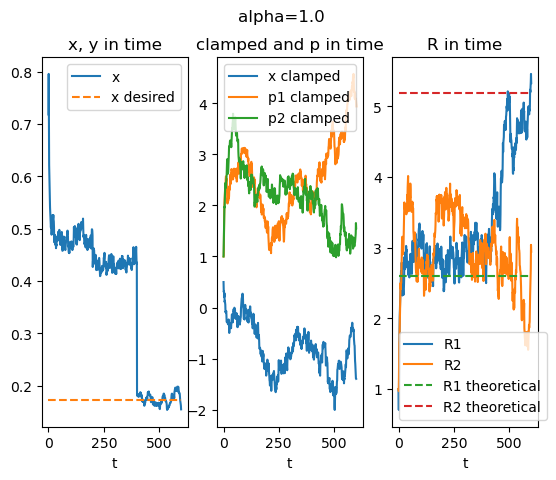

In [254]:
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 2.9, 3.0, 3.5, 4.0, 8.0])
# alpha_vec = np.column_stack((alpha_vec, alpha_vec))

alpha_vec = np.array([1.0])
task_type = 'Regression'
# task_type = 'Allostery'

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, supress=False, bc_noise=0.08)